In [1]:
import numpy as np
import pandas as pd
from fast_ml.model_development import train_valid_test_split
from string import punctuation
import re
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn.naive_bayes as naive_bayes
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shivamarora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shivamarora/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Utility Functions

In [2]:
def convert_tweet_tree_to_df(tweet_id, year):
    tweet_tree = pd.read_csv( 'twitter' + year + '/tree/' + str(tweet_id) + '.txt', 
                             header=None, sep=',', engine='python')
    tweet_tree.columns = ["P1", "Tw1", "Udf", "Tw2", "T2"]
    tweet_tree['P1'] = tweet_tree['P1'].str[1:]
    temp = tweet_tree['Udf'].str.split("\]->\[", n = 1, expand = True)
    tweet_tree['T1'] = temp[0]
    tweet_tree['P2'] = temp[1]
    tweet_tree = tweet_tree[['P1','Tw1','T1','P2','Tw2','T2']]
    tweet_tree['T2'] = tweet_tree['T2'].str[:-1]
    return tweet_tree

In [3]:
def get_tweet_publisher(tweet, year, _):
    tweet_df = convert_tweet_tree_to_df(tweet['id'], year)
    return tweet_df['P2'][0][1:-1]

In [4]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in punctuation])
    return punctuationfree

In [5]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def remove_emoticons(text):
    return emoji_pattern.sub(r'', text)
    

In [6]:
def tokenization(text):
    return word_tokenize(str(text))

In [7]:
from nltk.corpus import stopwords
stopWords = stopwords.words('english')
def remove_stopwords(text):
    output= [i for i in text if i not in stopWords]
    return output

In [8]:
porter_stemmer = PorterStemmer()
def stemming(text):
    stem_text = [porter_stemmer.stem(word) for word in text]
    return stem_text

In [9]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

## Reading Datasets

In [10]:
data_15 = pd.read_csv('twitter15/source_tweets.txt', sep="\t", header=None)
data_15.columns = ["id", "content"]

In [11]:
labels_15 = pd.read_csv('twitter15/label.txt', sep=":", header=None)
labels_15.columns = ["label", "id"]

In [12]:
data_15 = data_15.join(labels_15.set_index('id'), on='id')

In [13]:
data_15['publisher'] = data_15.apply(get_tweet_publisher, axis=1, args=("15", _))

In [14]:
data_15.head()

,id,content,label,publisher
0,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified,431917957
1,714598641827246081,an open letter to trump voters from his top st...,unverified,94215989
2,691809004356501505,america is a nation of second chances —@potus ...,non-rumor,30313925
3,693204708933160960,"brandon marshall visits and offers advice, sup...",non-rumor,2557521
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,true,2883841


In [15]:
data_15.shape

(1490, 4)

In [16]:
data_15.count()

id           1490
content      1490
label        1490
publisher    1490
dtype: int64

In [17]:
data_15.dtypes

id            int64
content      object
label        object
publisher    object
dtype: object

In [18]:
data_16 = pd.read_csv('twitter16/source_tweets.txt', sep="\t", header=None)
data_16.columns = ["id", "content"]

In [19]:
labels_16 = pd.read_csv('twitter16/label.txt', sep=":", header=None)
labels_16.columns = ["label", "id"]

In [20]:
data_16 = data_16.join(labels_16.set_index('id'), on='id')

In [21]:
data_16['publisher'] = data_16.apply(get_tweet_publisher, axis=1, args=("16", _))

In [22]:
data_16.head()

,id,content,label,publisher
0,656955120626880512,correct predictions in back to the future ii URL,false,1942819082
1,615689290706595840,.@whitehouse in rainbow colors for #scotusmarr...,true,44945327
2,613404935003217920,cops bought the alleged church shooter burger ...,false,14511951
3,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified,431917957
4,714598641827246081,an open letter to trump voters from his top st...,unverified,94215989


In [23]:
data_16.shape

(818, 4)

In [24]:
data_16.count()

id           818
content      818
label        818
publisher    818
dtype: int64

In [25]:
data_16.dtypes

id            int64
content      object
label        object
publisher    object
dtype: object

In [26]:
data = pd.concat([data_15, data_16], ignore_index=True)

In [27]:
data

,id,content,label,publisher
0,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified,431917957
1,714598641827246081,an open letter to trump voters from his top st...,unverified,94215989
2,691809004356501505,america is a nation of second chances —@potus ...,non-rumor,30313925
3,693204708933160960,"brandon marshall visits and offers advice, sup...",non-rumor,2557521
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,true,2883841
...,...,...,...,...
2303,693546915892428800,jeb bush campaign kicks off 3-state farewell t...,non-rumor,14075928
2304,544269749405097984,breaking: live coverage of hostage situation u...,true,15250661
2305,760109079133990912,“after school satan clubs”? URL,unverified,44945327
2306,779633844680962048,this network of tunnels is from the stone age ...,unverified,918346674


In [28]:
data.shape

(2308, 4)

In [29]:
len(data["id"].unique())

2139

In [30]:
data = data.drop_duplicates(subset=None, keep='first', inplace=False)

In [31]:
data = data.reset_index()

In [32]:
data

,index,id,content,label,publisher
0,0,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified,431917957
1,1,714598641827246081,an open letter to trump voters from his top st...,unverified,94215989
2,2,691809004356501505,america is a nation of second chances —@potus ...,non-rumor,30313925
3,3,693204708933160960,"brandon marshall visits and offers advice, sup...",non-rumor,2557521
4,4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,true,2883841
...,...,...,...,...,...
2134,2302,693171092555431936,watch: tommy chong made a pro-bernie sanders v...,non-rumor,16664681
2135,2303,693546915892428800,jeb bush campaign kicks off 3-state farewell t...,non-rumor,14075928
2136,2304,544269749405097984,breaking: live coverage of hostage situation u...,true,15250661
2137,2306,779633844680962048,this network of tunnels is from the stone age ...,unverified,918346674


In [33]:
len(data["publisher"].unique())

906

In [186]:
data['label'].value_counts()

3    579
2    579
0    575
1    406
Name: label, dtype: int64

## Preprocessing

In [34]:
#Punctuation Removal
data['content']= data['content'].apply(lambda x:remove_punctuation(x))

In [35]:
#Emoticons Removal
data['content']= data['content'].apply(lambda x:remove_emoticons(x))

In [36]:
#Numbers Removal
remove_digits = str.maketrans('', '', digits)
data['content'] = data['content'].apply(lambda x: x.translate(remove_digits))

In [37]:
#lowering the text
data['content']= data['content'].apply(lambda x: x.lower())

In [38]:
#tokenization
data['content']= data['content'].apply(lambda x: tokenization(x))

In [39]:
#Removing stop words
data['content']= data['content'].apply(lambda x:remove_stopwords(x))

In [40]:
#Stemming
data['content']=data['content'].apply(lambda x: stemming(x))

In [41]:
#Lemmatization
data['content']=data['content'].apply(lambda x:lemmatizer(x))

In [42]:
data['content'].head()

0    [ca, kkk, grand, wizard, endors, hillaryclinto...
1    [open, letter, trump, voter, top, strategisttu...
2    [america, nation, second, chanc, —potu, new, r...
3    [brandon, marshal, visit, offer, advic, suppor...
4    [rip, elli, may, clampett, sad, learn, beverly...
Name: content, dtype: object

In [43]:
data['label'].value_counts()

true          579
non-rumor     579
false         575
unverified    406
Name: label, dtype: int64

In [195]:
len(data_16['publisher'].unique())

425

In [192]:
data_16['label'].value_counts()

true          207
false         205
non-rumor     205
unverified    201
Name: label, dtype: int64

In [44]:
label_map = {'false' : 0, 'unverified' : 1, 'non-rumor' : 2, 'true' : 3}

In [45]:
data['label'] = data['label'].map(label_map)

### Encoding Publisher

In [46]:
labelencoder = LabelEncoder()

In [47]:
unique_publishers = data['publisher'].unique()
data['publisher_code'] = labelencoder.fit_transform(data['publisher'])

In [202]:
data.drop(['index'], axis=1).iloc[:,:5]

,id,content,label,publisher,publisher_code
0,731166399389962242,"[ca, kkk, grand, wizard, endors, hillaryclinto...",1,431917957,670
1,714598641827246081,"[open, letter, trump, voter, top, strategisttu...",1,94215989,886
2,691809004356501505,"[america, nation, second, chanc, —potu, new, r...",2,30313925,566
3,693204708933160960,"[brandon, marshal, visit, offer, advic, suppor...",2,2557521,494
4,551099691702956032,"[rip, elli, may, clampett, sad, learn, beverly...",3,2883841,547
...,...,...,...,...,...
2134,693171092555431936,"[watch, tommi, chong, made, proberni, sander, ...",2,16664681,245
2135,693546915892428800,"[jeb, bush, campaign, kick, state, farewel, to...",2,14075928,108
2136,544269749405097984,"[break, live, coverag, hostag, situat, unfold,...",3,15250661,168
2137,779633844680962048,"[network, tunnel, stone, age, howev, one, know...",1,918346674,876


In [49]:
enc = OneHotEncoder(handle_unknown='ignore')

In [50]:
enc_df = pd.DataFrame(enc.fit_transform(data[['publisher_code']]).toarray())
enc_df.shape

(2139, 906)

In [51]:
data = data.join(enc_df)
data

,index,id,content,label,publisher,publisher_code,0,1,2,3,...,896,897,898,899,900,901,902,903,904,905
0,0,731166399389962242,"[ca, kkk, grand, wizard, endors, hillaryclinto...",1,431917957,670,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,714598641827246081,"[open, letter, trump, voter, top, strategisttu...",1,94215989,886,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,691809004356501505,"[america, nation, second, chanc, —potu, new, r...",2,30313925,566,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,693204708933160960,"[brandon, marshal, visit, offer, advic, suppor...",2,2557521,494,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,551099691702956032,"[rip, elli, may, clampett, sad, learn, beverly...",3,2883841,547,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,2302,693171092555431936,"[watch, tommi, chong, made, proberni, sander, ...",2,16664681,245,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2135,2303,693546915892428800,"[jeb, bush, campaign, kick, state, farewel, to...",2,14075928,108,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2136,2304,544269749405097984,"[break, live, coverag, hostag, situat, unfold,...",3,15250661,168,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2137,2306,779633844680962048,"[network, tunnel, stone, age, howev, one, know...",1,918346674,876,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split & Vectorization

In [52]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(data, target = 'label', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1)

In [53]:
print(y_train.value_counts())

2    467
3    465
0    453
1    326
Name: label, dtype: int64


In [187]:
print(y_valid.value_counts())

3    60
0    59
2    57
1    38
Name: label, dtype: int64


In [55]:
print(y_test.value_counts())

0    63
2    55
3    54
1    42
Name: label, dtype: int64


In [56]:
def identity_tokenizer(text):
    return text
tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False, max_features=1000)
tfidf_vectorizer.fit(data['content'])

TfidfVectorizer(lowercase=False, max_features=1000, stop_words='english',
                tokenizer=<function identity_tokenizer at 0x7fa0a0aa5160>)

In [57]:
tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train['content'])

In [190]:
tfidf_train_vectors

<1711x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 12056 stored elements in Compressed Sparse Row format>

In [58]:
tfidf_valid_vectors = tfidf_vectorizer.fit_transform(X_valid['content'])

In [59]:
tfidf_test_vectors = tfidf_vectorizer.fit_transform(X_test['content'])

# Classification

## SVM Multiclass Classification

In [60]:
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

In [61]:
labels = [0,1,2,3]
def plot_cm(y_true,y_pred,labels):
  cm = confusion_matrix(y_true, y_pred)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax, fmt="d")
  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
  plt.show()

Kernel: linear
Validation
              precision    recall  f1-score   support

           0       0.25      0.24      0.24        59
           1       0.22      0.26      0.24        38
           2       0.24      0.25      0.24        57
           3       0.22      0.20      0.21        60

    accuracy                           0.23       214
   macro avg       0.23      0.24      0.23       214
weighted avg       0.23      0.23      0.23       214



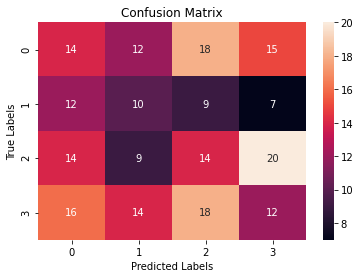


Testing
              precision    recall  f1-score   support

           0       0.33      0.38      0.35        63
           1       0.28      0.26      0.27        42
           2       0.25      0.24      0.24        55
           3       0.28      0.26      0.27        54

    accuracy                           0.29       214
   macro avg       0.29      0.28      0.28       214
weighted avg       0.29      0.29      0.29       214



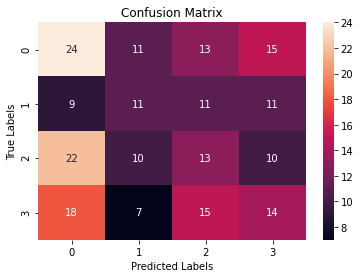

In [62]:
clf = svm.SVC(kernel='linear')
clf.fit(tfidf_train_vectors,y_train)
y_pred_valid = clf.predict(tfidf_valid_vectors)
y_pred_test = clf.predict(tfidf_test_vectors)

print('Kernel: linear')
print('Validation')
print(classification_report(y_valid,y_pred_valid))
plot_cm(y_valid,y_pred_valid,labels)
print()
print('Testing')
print(classification_report(y_test,y_pred_test))
plot_cm(y_test,y_pred_test,labels)

Kernel: rbf
Validation
              precision    recall  f1-score   support

           0       0.25      0.22      0.24        59
           1       0.33      0.18      0.24        38
           2       0.26      0.49      0.34        57
           3       0.29      0.17      0.21        60

    accuracy                           0.27       214
   macro avg       0.28      0.27      0.26       214
weighted avg       0.28      0.27      0.26       214



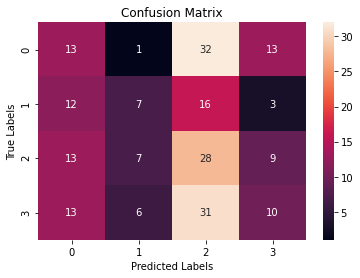


Testing
              precision    recall  f1-score   support

           0       0.34      0.35      0.35        63
           1       0.16      0.07      0.10        42
           2       0.27      0.49      0.35        55
           3       0.22      0.13      0.16        54

    accuracy                           0.28       214
   macro avg       0.25      0.26      0.24       214
weighted avg       0.26      0.28      0.25       214



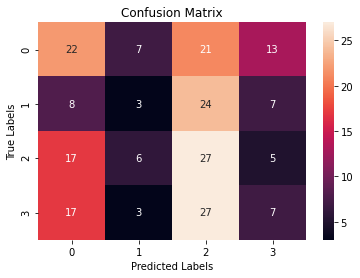

In [63]:
clf = svm.SVC(kernel='rbf')
clf.fit(tfidf_train_vectors,y_train)
y_pred_valid = clf.predict(tfidf_valid_vectors)
y_pred_test = clf.predict(tfidf_test_vectors)

print('Kernel: rbf')
print('Validation')
print(classification_report(y_valid,y_pred_valid))
plot_cm(y_valid,y_pred_valid,labels)
print()
print('Testing')
print(classification_report(y_test,y_pred_test))
plot_cm(y_test,y_pred_test,labels)

Kernel: sigmoid
Validation
              precision    recall  f1-score   support

           0       0.24      0.22      0.23        59
           1       0.22      0.29      0.25        38
           2       0.26      0.25      0.25        57
           3       0.23      0.22      0.22        60

    accuracy                           0.24       214
   macro avg       0.24      0.24      0.24       214
weighted avg       0.24      0.24      0.24       214



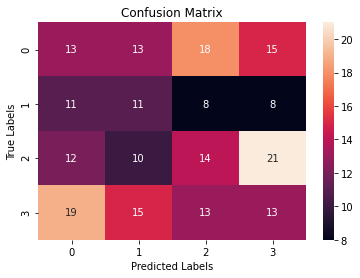


Testing
              precision    recall  f1-score   support

           0       0.32      0.40      0.36        63
           1       0.26      0.21      0.23        42
           2       0.22      0.20      0.21        55
           3       0.30      0.30      0.30        54

    accuracy                           0.29       214
   macro avg       0.28      0.28      0.28       214
weighted avg       0.28      0.29      0.28       214



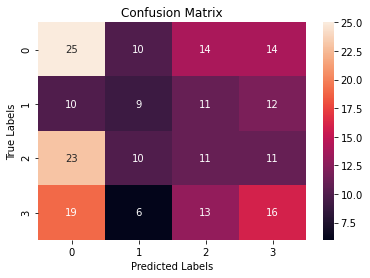

In [64]:
clf = svm.SVC(kernel='sigmoid')
clf.fit(tfidf_train_vectors,y_train)
y_pred_valid = clf.predict(tfidf_valid_vectors)
y_pred_test = clf.predict(tfidf_test_vectors)

print('Kernel: sigmoid')
print('Validation')
print(classification_report(y_valid,y_pred_valid))
plot_cm(y_valid,y_pred_valid,labels)
print()
print('Testing')
print(classification_report(y_test,y_pred_test))
plot_cm(y_test,y_pred_test,labels)

## LSTM & BiLSTM

In [65]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [66]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, Input, Concatenate, TimeDistributed
from tensorflow.keras.utils import plot_model

In [67]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

### LSTM - TEXT ONLY

In [68]:
model = Sequential()
model.add(Embedding(input_dim=1000, input_length=1000, output_dim=4))
model.add(Dropout(rate=0.4))
model.add(LSTM(units=4))
model.add(Dropout(rate=0.4))
model.add(Dense(units=100,  activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=6, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 4)           4000      
                                                                 
 dropout (Dropout)           (None, 1000, 4)           0         
                                                                 
 lstm (LSTM)                 (None, 4)                 144       
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 100)               500       
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 6

In [69]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])


In [70]:
history = model.fit(
    tfidf_train_vectors.toarray(), 
    y_train, 
    validation_data=[tfidf_valid_vectors.toarray(), y_valid],
    epochs = 5
)

Epoch 1/5
54/54 [==============================] - 19s 298ms/step - loss: 1.7069 - accuracy: 0.2688 - val_loss: 1.5486 - val_accuracy: 0.2804
Epoch 2/5
54/54 [==============================] - 16s 293ms/step - loss: 1.4737 - accuracy: 0.2718 - val_loss: 1.3974 - val_accuracy: 0.2804
Epoch 3/5
54/54 [==============================] - 13s 246ms/step - loss: 1.4172 - accuracy: 0.2805 - val_loss: 1.3855 - val_accuracy: 0.2804
Epoch 4/5
54/54 [==============================] - 14s 265ms/step - loss: 1.4271 - accuracy: 0.2537 - val_loss: 1.3806 - val_accuracy: 0.2804
Epoch 5/5
54/54 [==============================] - 13s 242ms/step - loss: 1.4049 - accuracy: 0.2759 - val_loss: 1.3794 - val_accuracy: 0.2804


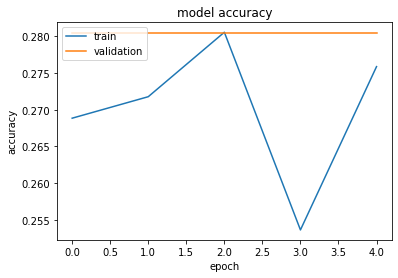

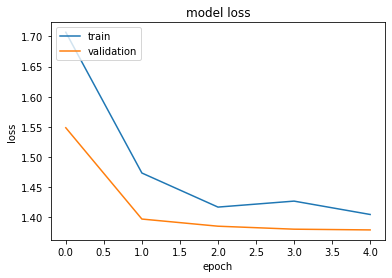

In [71]:
plot_history(history)

In [72]:
score, acc = model.evaluate(tfidf_test_vectors.toarray(), y_test)
print('Test score:', score)
print('Test accuracy:', acc)

7/7 [==============================] - 0s 48ms/step - loss: 1.3877 - accuracy: 0.2523
Test score: 1.3876721858978271
Test accuracy: 0.25233644247055054


In [73]:
y_probas = model.predict(tfidf_test_vectors.toarray())
y_pred = y_probas.argmax(axis=-1)

7/7 [==============================] - 1s 46ms/step


In [74]:
print(classification_report(y_true=y_test, y_pred=y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00        63
           1       1.00      0.00      0.00        42
           2       1.00      0.00      0.00        55
           3       0.25      1.00      0.40        54

    accuracy                           0.25       214
   macro avg       0.81      0.25      0.10       214
weighted avg       0.81      0.25      0.10       214



### Bi-LSTM - TEXT ONLY

In [75]:
model = Sequential()
model.add(Embedding(input_dim=1000, input_length=1000, output_dim=4))
model.add(Dropout(rate=0.4))
model.add(Bidirectional(LSTM(units=4)))
model.add(Dropout(rate=0.4))
model.add(Dense(units=100,  activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=6, activation='sigmoid'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 4)           4000      
                                                                 
 dropout_3 (Dropout)         (None, 1000, 4)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 8)                288       
 l)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 100)               900       
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                      

In [76]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


In [77]:
history = model.fit(
    tfidf_train_vectors.toarray(), 
    y_train, 
    validation_data=[tfidf_valid_vectors.toarray(), y_valid],
    epochs = 5
)


Epoch 1/5
54/54 [==============================] - 23s 348ms/step - loss: 1.6896 - accuracy: 0.2618 - val_loss: 1.5108 - val_accuracy: 0.2664
Epoch 2/5
54/54 [==============================] - 18s 334ms/step - loss: 1.4627 - accuracy: 0.2788 - val_loss: 1.3932 - val_accuracy: 0.2664
Epoch 3/5
54/54 [==============================] - 19s 361ms/step - loss: 1.4272 - accuracy: 0.2683 - val_loss: 1.3832 - val_accuracy: 0.2664
Epoch 4/5
54/54 [==============================] - 18s 332ms/step - loss: 1.4138 - accuracy: 0.2665 - val_loss: 1.3827 - val_accuracy: 0.2664
Epoch 5/5
54/54 [==============================] - 18s 341ms/step - loss: 1.4119 - accuracy: 0.2613 - val_loss: 1.3776 - val_accuracy: 0.2664


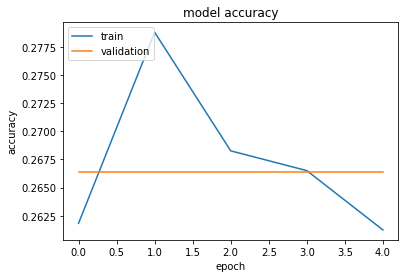

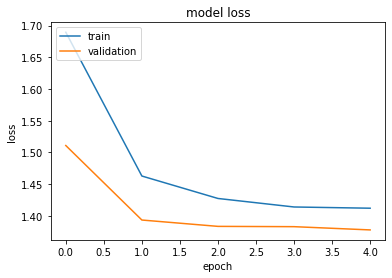

In [78]:
plot_history(history)


In [79]:
score, acc = model.evaluate(tfidf_test_vectors.toarray(), y_test)
print('Test score:', score)
print('Test accuracy:', acc)

7/7 [==============================] - 1s 69ms/step - loss: 1.3856 - accuracy: 0.2570
Test score: 1.385594129562378
Test accuracy: 0.257009357213974


In [80]:
y_probas = model.predict(tfidf_test_vectors.toarray())
y_pred = y_probas.argmax(axis=-1)

7/7 [==============================] - 1s 86ms/step


In [108]:
print(classification_report(y_true=y_test, y_pred=y_pred, zero_division=0))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.00      0.00      0.00        42
           2       0.26      1.00      0.41        55
           3       0.00      0.00      0.00        54

    accuracy                           0.26       214
   macro avg       0.06      0.25      0.10       214
weighted avg       0.07      0.26      0.11       214



### LSTM - Text & Publisher

In [111]:
publisher_train = X_train['publisher_code']
publisher_valid = X_valid['publisher_code']
publisher_test = X_test['publisher_code']

In [110]:
publisher_train

324     484
1044    684
860     872
1252    566
10      361
       ... 
2114    566
1218    788
112      73
611     533
1821    789
Name: publisher_code, Length: 1711, dtype: int64

In [166]:
publisher_input = Input(shape=(1,))
publisher_features = (Embedding(input_dim=906, input_length=1, output_dim=1000))(publisher_input)
publisher_features = Dropout(rate=0.4)(publisher_features)
publisher_features = LSTM(units=4)(publisher_features)

In [167]:
text_input = Input(shape=(1000,))
text_features = (Embedding(input_dim=1000, input_length=1000, output_dim=1000))(text_input)
text_features = Dropout(rate=0.4)(text_features)
text_features = LSTM(units=4)(text_features)

In [168]:
x = Concatenate()([publisher_features, text_features])
x = Dropout(rate=0.5)(x)
model_output = Dense(units=6, activation='sigmoid')(x)

model = Model([publisher_input, text_input], model_output, name='model')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 1000)]       0           []                               
                                                                                                  
 embedding_23 (Embedding)       (None, 1, 1000)      906000      ['input_23[0][0]']               
                                                                                                  
 embedding_24 (Embedding)       (None, 1000, 1000)   1000000     ['input_24[0][0]']               
                                                                                              

In [169]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [170]:
history = model.fit(
    [publisher_train, tfidf_train_vectors.toarray()], 
    y_train, 
    validation_data=[[publisher_valid, tfidf_valid_vectors.toarray()], y_valid],
    epochs = 5
)

Epoch 1/5
54/54 [==============================] - 43s 747ms/step - loss: 1.6198 - accuracy: 0.2776 - val_loss: 1.4790 - val_accuracy: 0.4065
Epoch 2/5
54/54 [==============================] - 41s 752ms/step - loss: 1.4729 - accuracy: 0.3735 - val_loss: 1.3539 - val_accuracy: 0.5234
Epoch 3/5
54/54 [==============================] - 39s 731ms/step - loss: 1.3394 - accuracy: 0.4722 - val_loss: 1.2718 - val_accuracy: 0.5234
Epoch 4/5
54/54 [==============================] - 37s 678ms/step - loss: 1.2460 - accuracy: 0.5137 - val_loss: 1.2244 - val_accuracy: 0.4860
Epoch 5/5
54/54 [==============================] - 37s 680ms/step - loss: 1.1720 - accuracy: 0.5400 - val_loss: 1.1982 - val_accuracy: 0.5234


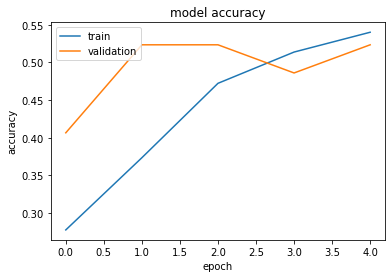

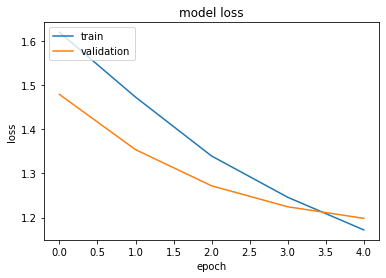

In [171]:
plot_history(history)

In [172]:
score, acc = model.evaluate([publisher_test ,tfidf_test_vectors.toarray()], y_test)
print('Test score:', score)
print('Test accuracy:', acc)

7/7 [==============================] - 1s 182ms/step - loss: 1.1636 - accuracy: 0.5187
Test score: 1.163622260093689
Test accuracy: 0.5186915993690491


In [174]:
y_probas = model.predict([publisher_test, tfidf_test_vectors.toarray()])
y_pred = y_probas.argmax(axis=-1)

7/7 [==============================] - 2s 197ms/step


In [175]:
print(classification_report(y_true=y_test, y_pred=y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.48      0.73      0.58        63
           1       1.00      0.00      0.00        42
           2       0.57      0.89      0.70        55
           3       0.50      0.30      0.37        54

    accuracy                           0.52       214
   macro avg       0.64      0.48      0.41       214
weighted avg       0.61      0.52      0.44       214



### BiLSTM - Text & Publisher

In [176]:
publisher_input = Input(shape=(1,))
publisher_features = (Embedding(input_dim=906, input_length=1, output_dim=1000))(publisher_input)
publisher_features = Dropout(rate=0.4)(publisher_features)
publisher_features = Bidirectional(LSTM(units=4))(publisher_features)

In [177]:
text_input = Input(shape=(1000,))
text_features = (Embedding(input_dim=1000, input_length=1000, output_dim=1000))(text_input)
text_features = Dropout(rate=0.4)(text_features)
text_features = Bidirectional(LSTM(units=4))(text_features)

In [178]:
x = Concatenate()([publisher_features, text_features])
x = Dropout(rate=0.5)(x)
model_output = Dense(units=6, activation='sigmoid')(x)

model = Model([publisher_input, text_input], model_output, name='model')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 1000)]       0           []                               
                                                                                                  
 embedding_25 (Embedding)       (None, 1, 100)       90600       ['input_25[0][0]']               
                                                                                                  
 embedding_26 (Embedding)       (None, 1000, 1000)   1000000     ['input_26[0][0]']               
                                                                                              

In [179]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [180]:
history = model.fit(
    [publisher_train, tfidf_train_vectors.toarray()], 
    y_train, 
    validation_data=[[publisher_valid, tfidf_valid_vectors.toarray()], y_valid],
    epochs = 5
)

Epoch 1/5
54/54 [==============================] - 64s 1s/step - loss: 1.6201 - accuracy: 0.2846 - val_loss: 1.5029 - val_accuracy: 0.2804
Epoch 2/5
54/54 [==============================] - 63s 1s/step - loss: 1.5402 - accuracy: 0.2800 - val_loss: 1.4298 - val_accuracy: 0.3411
Epoch 3/5
54/54 [==============================] - 61s 1s/step - loss: 1.4192 - accuracy: 0.3489 - val_loss: 1.2864 - val_accuracy: 0.5000
Epoch 4/5
54/54 [==============================] - 68s 1s/step - loss: 1.2631 - accuracy: 0.4401 - val_loss: 1.1855 - val_accuracy: 0.5561
Epoch 5/5
54/54 [==============================] - 80s 1s/step - loss: 1.1646 - accuracy: 0.5096 - val_loss: 1.1301 - val_accuracy: 0.5327


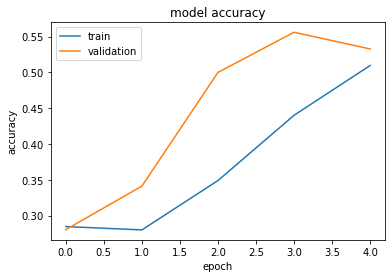

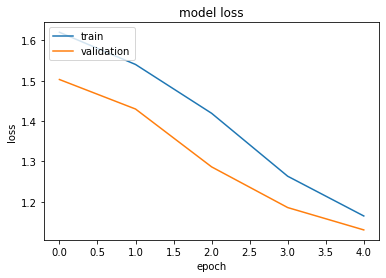

In [181]:
plot_history(history)

In [182]:
score, acc = model.evaluate([publisher_test ,tfidf_test_vectors.toarray()], y_test)
print('Test score:', score)
print('Test accuracy:', acc)

7/7 [==============================] - 3s 390ms/step - loss: 1.1400 - accuracy: 0.5140
Test score: 1.1399645805358887
Test accuracy: 0.514018714427948


In [183]:
y_probas = model.predict([publisher_test, tfidf_test_vectors.toarray()])
y_pred = y_probas.argmax(axis=-1)

7/7 [==============================] - 4s 368ms/step


In [184]:
print(classification_report(y_true=y_test, y_pred=y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.44      0.60      0.51        63
           1       1.00      0.00      0.00        42
           2       0.75      0.85      0.80        55
           3       0.38      0.46      0.42        54

    accuracy                           0.51       214
   macro avg       0.64      0.48      0.43       214
weighted avg       0.62      0.51      0.46       214

